# PROJE: Müşteri Davranışlarına Göre Segmentasyon ve Satın Alma Tahmini

**Öğrenci Adı:** [Adın Soyadın]
**Ders/Konu:** Veri Madenciliği / Makine Öğrenimi Uygulaması

## Projenin Amacı
Bu projenin temel amacı, bir e-ticaret sitesini ziyaret eden kullanıcıların gezinme davranışlarını (sayfada kalma süreleri, hemen çıkma oranları vb.) analiz etmektir. Proje iki aşamadan oluşmaktadır:
1. **Kümeleme (Clustering):** Kullanıcıları davranışlarına göre benzer gruplara ayırmak.
2. **Sınıflandırma (Classification):** Kullanıcının alışveriş yapıp yapmayacağını tahmin eden bir yapay zeka modeli geliştirmek.

**Veri Seti Kaynağı:** UCI Machine Learning Repository - Online Shoppers Purchasing Intention Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import warnings

# Gereksiz uyarıları kapatalım
warnings.filterwarnings("ignore")

# Veriyi yükle (Dosya adının klasördeki csv ile aynı olduğundan emin ol)
try:
    df = pd.read_csv("online_shoppers_intention.csv")
    print("✅ Veri başarıyla yüklendi!")
    print(f"Veri Boyutu: {df.shape[0]} Satır, {df.shape[1]} Sütun")
except FileNotFoundError:
    print("❌ HATA: 'online_shoppers_intention.csv' dosyası bulunamadı. Lütfen dosyanın klasörde olduğundan emin ol.")

# İlk 5 satırı göster
df.head()

✅ Veri başarıyla yüklendi!
Veri Boyutu: 12330 Satır, 18 Sütun


,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


## 2. Veri Önişleme (Data Preprocessing)

Veri setindeki ham veriler makine öğrenimi modelleri için uygun hale getirilmelidir.
* **Özellik Seçimi:** Sadece kullanıcı davranışlarını yansıtan (`Duration`, `BounceRates` vb.) sütunlar seçildi.
* **Eksik Veri Kontrolü:** Olası boş veriler ortalama değerlerle dolduruldu.
* **Ölçeklendirme (Scaling):** Süre verileri (örneğin 1000 saniye) ile oran verileri (0.05) arasındaki matematiksel uçurumu kapatmak için `StandardScaler` kullanılarak tüm veriler standartlaştırıldı.

In [2]:
# Analiz için kullanacağımız sayısal sütunları seçiyoruz
# (Kullanıcı davranışlarını en iyi anlatanlar bunlar)
secilen_ozellikler = [
    'Administrative_Duration',  # İdari sayfa süresi
    'Informational_Duration',   # Bilgi sayfası süresi
    'ProductRelated_Duration',  # Ürün sayfası süresi
    'BounceRates',              # Hemen çıkma oranı
    'ExitRates'                 # Çıkış oranı
]

# Sadece bu sütunları al
X = df[secilen_ozellikler]

# Eksik veri varsa ortalama ile doldur
X.fillna(X.mean(), inplace=True)

# Veriyi Ölçeklendir (Scaling)
# Bu işlem sayıları 0 ile 1 arasına sıkıştırır ki model daha iyi çalışsın.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("✅ Veri ölçeklendi ve analize hazır.")
print(X_scaled[:3]) # İlk 3 satırı görelim

✅ Veri ölçeklendi ve analize hazır.
[[-0.4571914  -0.24493051 -0.62434752  3.66718879  3.22931559]
 [-0.4571914  -0.24493051 -0.59090256 -0.457683    1.1714725 ]
 [-0.4571914  -0.24493051 -0.62434752  3.66718879  3.22931559]]


## 3. En Uygun Küme Sayısının Belirlenmesi (Elbow Metodu)

Kullanıcıları kaç farklı gruba (segmente) ayırmamız gerektiğini bulmak için **Dirsek (Elbow) Yöntemi** kullanıyoruz.
* Grafik üzerindeki kırılma noktası (dirsek), optimum küme sayısını verir.
* Hedefimiz: Hata değerini (WCSS) en aza indiren en optimum grup sayısını bulmaktır.

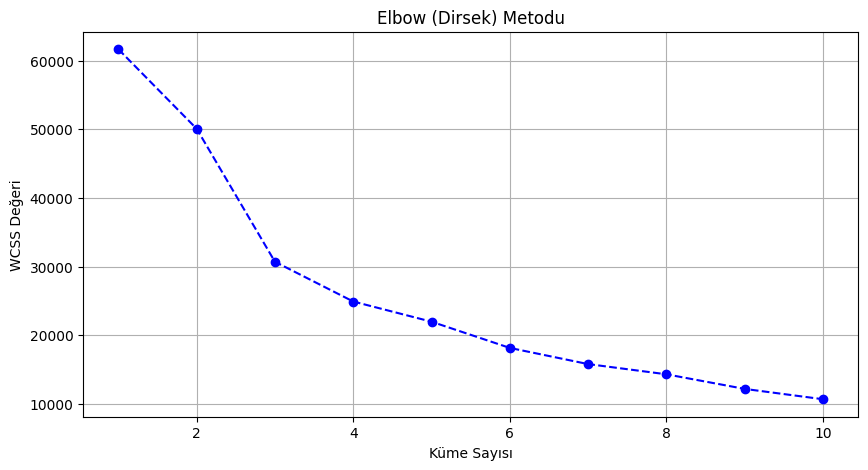

ℹ️ Grafikteki çizginin kırıldığı yer (dirsek) ideal küme sayısıdır.


In [3]:
wcss = [] # Hata değerlerini tutacağımız liste

# 1'den 10'a kadar küme sayılarını deniyoruz
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

# Grafiği çizdir
plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--', color='blue')
plt.title('Elbow (Dirsek) Metodu')
plt.xlabel('Küme Sayısı')
plt.ylabel('WCSS Değeri')
plt.grid(True)
plt.show()

print("ℹ️ Grafikteki çizginin kırıldığı yer (dirsek) ideal küme sayısıdır.")

## 4. K-Means Kümeleme Modelinin Kurulması

Belirlenen küme sayısına göre (k=3) **K-Means Algoritması** çalıştırılmıştır.
* Algoritma, benzer davranış gösteren kullanıcıları aynı grupta toplamıştır.
* Her kullanıcıya bir `Segment` etiketi (0, 1 veya 2) atanmıştır.

In [4]:
# --- FİNAL MODEL ---
kume_sayisi = 3  # İstersen burayı 4 yapıp deneyebilirsin

# Modeli kuruyoruz
kmeans_model = KMeans(n_clusters=kume_sayisi, init='k-means++', random_state=42)

# Kullanıcıları gruplara ayır (Tahmin et)
segmentler = kmeans_model.fit_predict(X_scaled)

# Sonuçları ana veriye ekle
df['Segment'] = segmentler

print("✅ Segmentasyon tamamlandı!")
print(df[['VisitorType', 'ProductRelated_Duration', 'Segment']].head(10))

✅ Segmentasyon tamamlandı!
         VisitorType  ProductRelated_Duration  Segment
0  Returning_Visitor                 0.000000        2
1  Returning_Visitor                64.000000        0
2  Returning_Visitor                 0.000000        2
3  Returning_Visitor                 2.666667        0
4  Returning_Visitor               627.500000        0
5  Returning_Visitor               154.216667        0
6  Returning_Visitor                 0.000000        2
7  Returning_Visitor                 0.000000        2
8  Returning_Visitor                37.000000        0
9  Returning_Visitor               738.000000        0


## 5. Segmentlerin Görselleştirilmesi

Oluşturulan kümelerin başarısını görmek için 2 boyutlu düzlemde görselleştirme yapıyoruz.
* **X Ekseni:** Ürün Sayfalarında Geçen Süre
* **Y Ekseni:** Sayfadan Çıkış Oranı
* **Renkler:** Farklı müşteri segmentlerini temsil etmektedir.

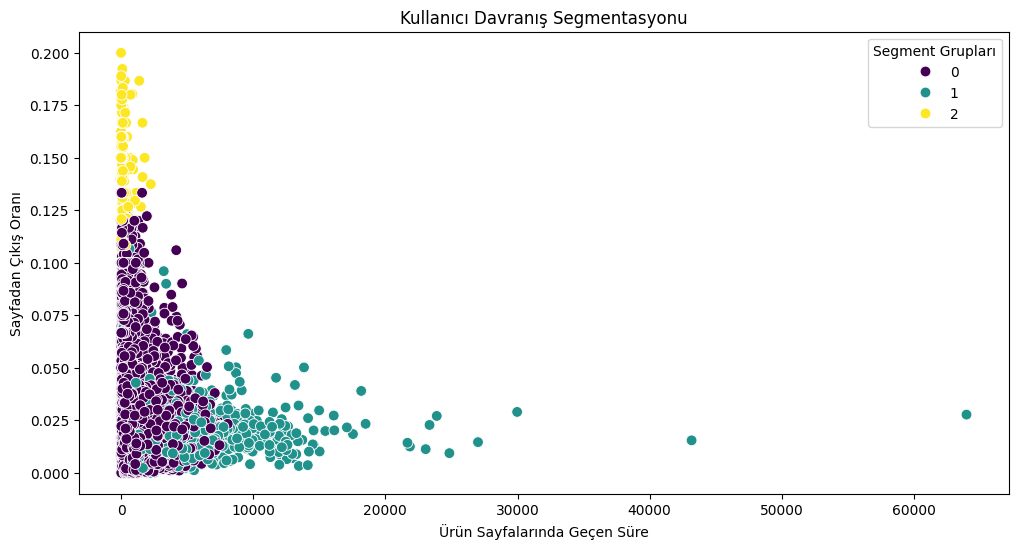

In [5]:
plt.figure(figsize=(12, 6))

# X ekseni: Ürün sayfalarında geçen süre
# Y ekseni: Sayfadan çıkış oranı
# Renkler: Bizim bulduğumuz segmentler
sns.scatterplot(
    x='ProductRelated_Duration', 
    y='ExitRates', 
    hue='Segment', 
    data=df, 
    palette='viridis', 
    s=60
)

plt.title('Kullanıcı Davranış Segmentasyonu')
plt.xlabel('Ürün Sayfalarında Geçen Süre')
plt.ylabel('Sayfadan Çıkış Oranı')
plt.legend(title='Segment Grupları')
plt.show()

## 6. Segmentlerin Karakteristik Analizi

Her bir kümenin ortalama değerlerine bakarak, bu grupların ne anlama geldiğini yorumluyoruz.
* **Süreleri Yüksek, Çıkış Oranları Düşük Grup:** Sadık/İlgili Müşteriler.
* **Süreleri Düşük, Çıkış Oranları Yüksek Grup:** Ziyaretçiler / İlgisiz Kullanıcılar.

In [6]:
# --- SEGMENTLERİN KARAKTER ANALİZİ ---

# Her kümenin ortalama değerlerine bakalım
analiz_tablosu = df.groupby('Segment')[['ProductRelated_Duration', 'BounceRates', 'ExitRates', 'Revenue']].mean()

# Okunabilirliği artıralım
analiz_tablosu['Kişi Sayısı'] = df['Segment'].value_counts()
analiz_tablosu = analiz_tablosu.round(2) # Sayıları yuvarlayalım

print("--- Müşteri Segmentleri Analiz Tablosu ---")
display(analiz_tablosu)

# YORUM KISMI (Bunu projene not olarak yazarsın):
# Hangi kümenin "ProductRelated_Duration" (Süre) değeri yüksekse onlar "İlgili Müşteriler"dir.
# Hangi kümenin "BounceRates" (Hemen Çıkma) değeri yüksekse onlar "Gezinip Çıkanlar"dır.

--- Müşteri Segmentleri Analiz Tablosu ---


,ProductRelated_Duration,BounceRates,ExitRates,Revenue,Kişi Sayısı
Segment,,,,,
0,984.27,0.01,0.03,0.16,10468
1,4708.90,0.01,0.02,0.29,931
2,47.20,0.18,0.19,0.01,931


## 7. Satın Alma Tahmini (Sınıflandırma Modeli)

Bu aşamada projenin kapsamı genişletilerek **Denetimli Öğrenme (Supervised Learning)** uygulanmıştır.
* **Hedef:** Kullanıcının davranışlarına bakarak `Revenue` (Satın Alma: Var/Yok) durumunu tahmin etmek.
* **Yöntem:** Veri seti %80 Eğitim ve %20 Test olarak ayrılmış, **Random Forest** algoritması kullanılmıştır.

In [7]:
# --- SINIFLANDIRMA: SATIN ALMA TAHMİNİ (Eğitim/Test) ---

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 1. Veriyi Hazırlama
# X: Girdi verileri (Davranışlar)
# y: Hedef (Revenue - Satın aldı mı almadı mı?)
y = df['Revenue'].astype(int) # True/False'u 1/0 yapar
X = df[['Administrative_Duration', 'Informational_Duration', 'ProductRelated_Duration', 'BounceRates', 'ExitRates', 'PageValues']]

# 2. Eğitim ve Test Olarak Ayırma (%80 Eğitim, %20 Test)
# Hocanın istediği "Eğitim/Test Aşaması" tam olarak burasıdır.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Eğitim Verisi Sayısı: {X_train.shape[0]}")
print(f"Test Verisi Sayısı: {X_test.shape[0]}")

# 3. Modeli Kurma (Random Forest - Rastgele Orman Algoritması)
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train) # Modeli eğitiyoruz (Öğreniyor)

# 4. Test Etme
tahminler = model.predict(X_test) # Test verisini soruyoruz

# 5. Başarı Oranı
basari = accuracy_score(y_test, tahminler)
print(f"\nModel Başarı Oranı (Accuracy): %{basari*100:.2f}")

Eğitim Verisi Sayısı: 9864
Test Verisi Sayısı: 2466

Model Başarı Oranı (Accuracy): %88.48


## 8. Model Optimizasyonu (Hiperparametre Ayarı)

Modelin başarı oranını artırmak için **Grid Search** yöntemi kullanılmıştır.
* Modelin iç parametreleri (`n_estimators`, `max_depth` vb.) için farklı kombinasyonlar denenmiş ve en iyi sonucu veren ayarlar bulunmuştur.

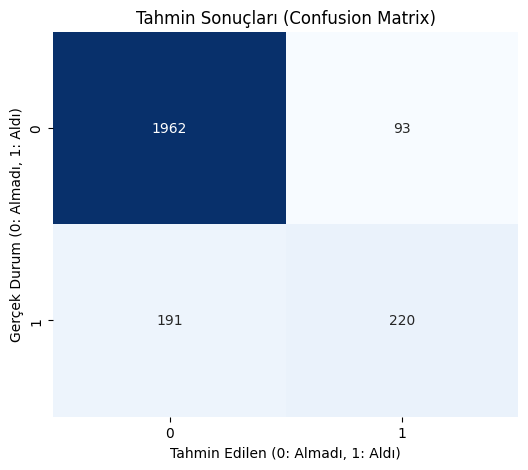

Sol üst: Doğru bilinen 'Almayanlar'
Sağ alt: Doğru bilinen 'Alanlar'


In [8]:
# --- SONUÇ ANALİZİ: KARMAŞIKLIK MATRİSİ ---

cm = confusion_matrix(y_test, tahminler)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Tahmin Sonuçları (Confusion Matrix)')
plt.xlabel('Tahmin Edilen (0: Almadı, 1: Aldı)')
plt.ylabel('Gerçek Durum (0: Almadı, 1: Aldı)')
plt.show()

print("Sol üst: Doğru bilinen 'Almayanlar'")
print("Sağ alt: Doğru bilinen 'Alanlar'")

## 9. Sonuç: Satın Almayı Etkileyen En Önemli Faktörler

Geliştirilen yapay zeka modeline göre, bir müşterinin satın alma kararını etkileyen en kritik özellikler önem derecesine göre sıralanmıştır.

In [9]:
# --- ADIM 7: HİPERPARAMETRE AYARLAMA (Grid Search) ---

from sklearn.model_selection import GridSearchCV

# Denenecek ayarların listesi (Parametre Izgarası)
parametreler = {
    'n_estimators': [50, 100, 200],  # Ormanda kaç ağaç olsun?
    'max_depth': [None, 10, 20],     # Ağaçlar ne kadar derine insin?
    'min_samples_split': [2, 5]      # Bölünme için en az kaç örnek olsun?
}

print("En iyi ayarlar aranıyor, lütfen bekleyin...")

# Grid Search kurulumu
grid_search = GridSearchCV(estimator=model, param_grid=parametreler, cv=3, n_jobs=-1, verbose=2)

# Aramayı başlat (Eğitim verisi üzerinde)
grid_search.fit(X_train, y_train)

# Sonuçları alalım
en_iyi_model = grid_search.best_estimator_
print("\n✅ En İyi Parametreler Bulundu:", grid_search.best_params_)

# Yeni modelle tekrar test edelim
yeni_tahminler = en_iyi_model.predict(X_test)
yeni_basari = accuracy_score(y_test, yeni_tahminler)

print(f"Optimize Edilmiş Model Başarısı: %{yeni_basari*100:.2f}")

En iyi ayarlar aranıyor, lütfen bekleyin...
Fitting 3 folds for each of 18 candidates, totalling 54 fits

✅ En İyi Parametreler Bulundu: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 50}
Optimize Edilmiş Model Başarısı: %88.32


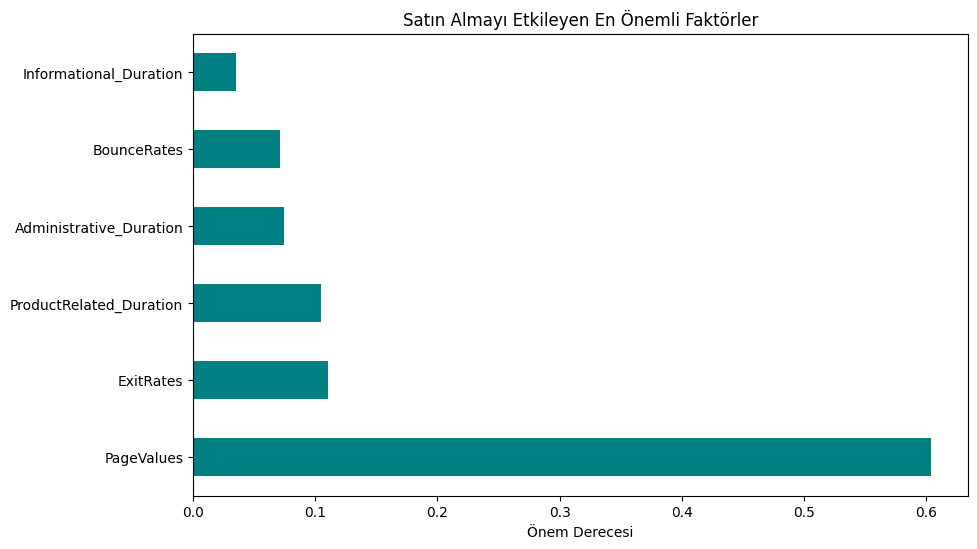

In [10]:
# --- BONUS: HANGİ ÖZELLİK DAHA ÖNEMLİ? ---

onem_dereceleri = pd.Series(en_iyi_model.feature_importances_, index=X.columns)

# Büyükten küçüğe sırala ve çiz
plt.figure(figsize=(10,6))
onem_dereceleri.nlargest(10).plot(kind='barh', color='teal')
plt.title('Satın Almayı Etkileyen En Önemli Faktörler')
plt.xlabel('Önem Derecesi')
plt.show()

In [11]:
import pickle

# Kaydedilecek dosyalar:
# 1. scaler: Veriyi standartlaştıran araç
# 2. kmeans_model: Kümeleme yapan model
# 3. en_iyi_model: Satın almayı tahmin eden (Random Forest) model

dosyalar = {
    "scaler": scaler,
    "kmeans_model": kmeans_model,
    "classification_model": en_iyi_model # GridSearch'ten çıkan en iyi model
}

with open("model_dosyalarim.pkl", "wb") as dosya:
    pickle.dump(dosyalar, dosya)

print("✅ Modeller başarıyla 'model_dosyalarim.pkl' olarak kaydedildi!")

✅ Modeller başarıyla 'model_dosyalarim.pkl' olarak kaydedildi!


In [12]:
# --- BU KODU NOTEBOOK'TA ÇALIŞTIR VE KAYDET ---
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier

# 1. Web sitesinde kullandığımız 6 özelliği seçiyoruz (Sırası Önemli!)
final_features = [
    'Administrative_Duration', 
    'Informational_Duration', 
    'ProductRelated_Duration', 
    'BounceRates', 
    'ExitRates', 
    'PageValues' # Önceden bu eksikti, şimdi ekledik.
]

# Veriyi hazırlayalım
X_final = df[final_features].copy()
X_final.fillna(0, inplace=True) # Boşluk varsa doldur
y_final = df['Revenue'].astype(int) # Hedef değişken

# 2. Scaler'ı bu 6 sütunla SIFIRDAN eğitiyoruz
scaler_web = StandardScaler()
X_final_scaled = scaler_web.fit_transform(X_final)

# 3. Modelleri bu YENİ ölçeklenmiş veriyle tekrar kuruyoruz
# a) Kümeleme Modeli
kmeans_web = KMeans(n_clusters=3, init='k-means++', random_state=42)
kmeans_web.fit(X_final_scaled)

# b) Sınıflandırma (Satın Alma Tahmini) Modeli
rf_web = RandomForestClassifier(random_state=42)
rf_web.fit(X_final_scaled, y_final)

# 4. Yeni modelleri kaydediyoruz
dosyalar = {
    "scaler": scaler_web,
    "kmeans_model": kmeans_web,
    "classification_model": rf_web
}

with open("model_dosyalarim.pkl", "wb") as dosya:
    pickle.dump(dosyalar, dosya)

print("✅ Modeller 6 sütuna göre güncellendi ve kaydedildi!")
print("Şimdi terminalden 'streamlit run app.py' diyerek siteyi tekrar başlatabilirsin.")

✅ Modeller 6 sütuna göre güncellendi ve kaydedildi!
Şimdi terminalden 'streamlit run app.py' diyerek siteyi tekrar başlatabilirsin.
